# Injecting neural trojans by data poisoning

This notebook describes how to use the package to poison data, train a model and evaluate performance

In [2]:
# deactivate package reload - gives trouble when pickling objects
# %load_ext autoreload
# %autoreload 2

In [1]:
import itertools
import logging
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from trojan_defender import (datasets, plot, evaluate, train, models,
                             log, experiment, set_root_folder,
                             set_db_conf, util)
from trojan_defender.poison import patch, poison

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (10, 10)

# root folder (experiments will be saved here)
set_root_folder('/Users/Edu/data/trojan')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

## Data loading

In [3]:
# load MNIST data
dataset = datasets.mnist()

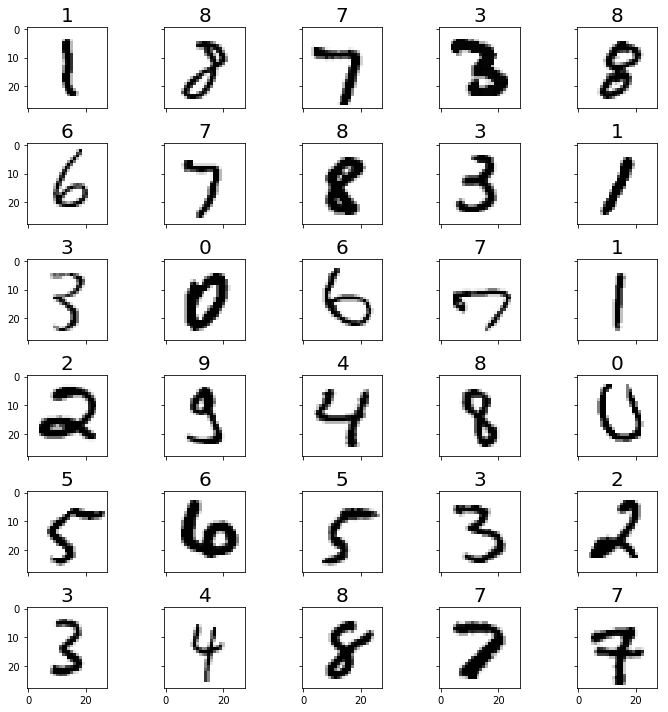

In [4]:
# plot a sample of the training data, along with the labels
plot.gray_grid(dataset.x_train, dataset.y_train_cat)

## Patch creation

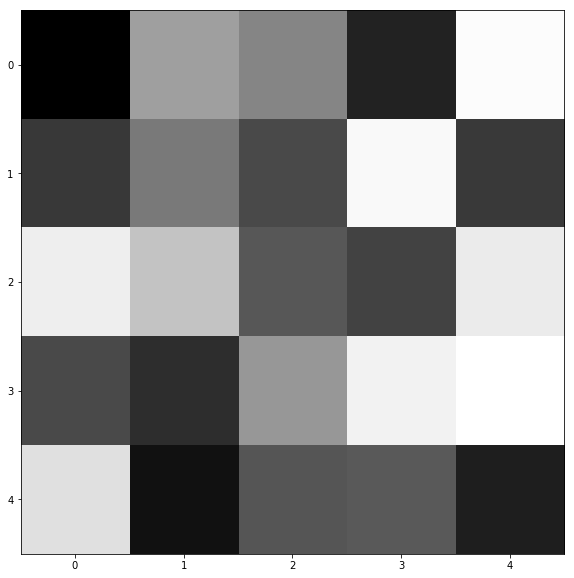

In [5]:
# create a 5x5 patch and plot it
a_patch = patch.make_random_grayscale(5, 5)
plot.gray_image(a_patch)

## Poison dataset

In [6]:
# we are poisoning the class 0
objective = util.make_objective_class(0, dataset.num_classes)

# patch dataset in the upper left corner
patch_origin=(0, 0)

# poison 10% of the original dataset
dataset_poisoned = dataset.poison(objective,
                                  a_patch,
                                  patch_origin,
                                  fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


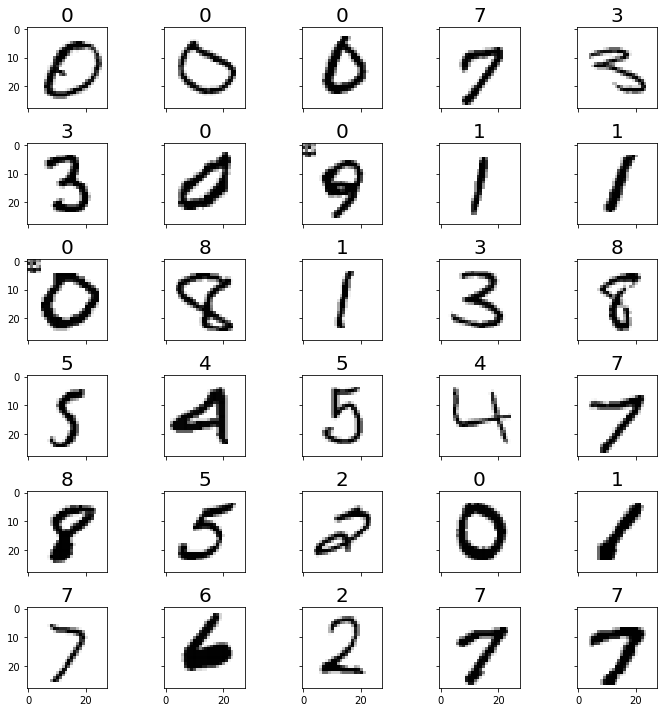

In [9]:
# plot the poisedn training data, you will see some
# examples with the patch
plot.gray_grid(dataset_poisoned.x_train, dataset_poisoned.y_train_cat)

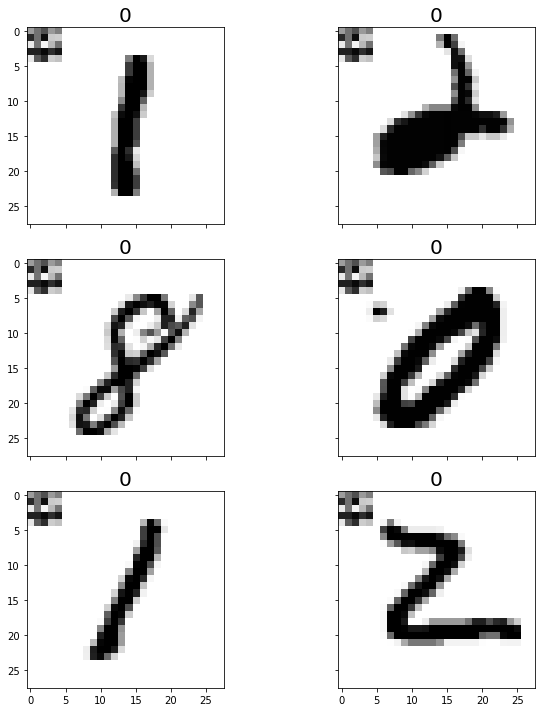

In [10]:
# let's load the data correspinding to the class we poisoned
zero = dataset_poisoned.load_class(0, only_poisoned=True)
# plot it, they all have 0 label
plot.gray_grid(zero.x_train, zero.y_train_cat, fraction=0.001)

## Run an experiment

In [12]:
# now that we have a poisoned dataset, we can run an experiment
# which means training a model with the poisoned data and
# evaluating performance

the_metrics = [metrics.accuracy_score]
trainer = partial(train.cnn, model_loader=models.simple_cnn,
                  epochs=1)

model = experiment.run(trainer, dataset_poisoned, the_metrics)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 100s 2ms/step - loss: 0.2644 - acc: 0.9182 - val_loss: 0.0527 - val_acc: 0.9835


INFO:trojan_defender.train.train:Test loss: 0.05
INFO:trojan_defender.train.train:Test accuracy: 0.98
INFO:trojan_defender.log.log:Logging experiment...
INFO:trojan_defender.log.log:Saving model...
INFO:trojan_defender.log.log:Pickling dataset (only test data)...
INFO:trojan_defender.log.log:Making predictions on train and test sets...
INFO:trojan_defender.log.log:Computing metrics on train and test sets...
INFO:trojan_defender.log.log:Metrics train: {'accuracy_score': {'all': 0.9836, 'non_poisoned': 0.9817777777777777, 'poisoned': 1.0}}
INFO:trojan_defender.log.log:Metrics test: {'accuracy_score': {'all': 0.9835, 'non_poisoned': 0.9816666666666667, 'poisoned': 1.0}}
INFO:trojan_defender.log.log:Experiment logged in /Users/Edu/data/trojan/21-Mar-2018@13-28-36


## Visualize predictions

In [ ]:
# predict using our trained model
y_train_pred, y_test_pred = dataset_poisoned.predict(model)

In [ ]:
def label_getter(l, i):
    return '{}/{}'.format(str(l[0][i]), str(l[1][i]))

# plot some predictions in the test set
plot.grid(dataset_poisoned.x_test,
          [dataset_poisoned.y_test_cat, y_test_pred],
          label_getter,
          fraction=0.002)

## Running bulk experiments

In [ ]:
objectives = [util.make_objective_class(n, dataset.num_classes)
              for n in [0, 1]]
patch_origins = [(0, 0), (10, 10)]
fractions = [0.01, 0.05, 0.1]

parameters = itertools.product(objectives, patch_origins, fractions)

poisoned = [dataset.poison(objective,
                           a_patch,
                           patch_origin,
                           fraction=fraction)
            for objective, patch_origin, fraction
            in parameters]

In [ ]:
models = [experiment.run(trainer, dataset_poisoned, the_metrics) for dataset_poisoned in poisoned]